In [1]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_data) = wavfile.read('./data/01_gain.wav')


In [2]:
import pandas as pd

In [3]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

,L,R
0,1,-1
1,-5,-6
2,-11,-12
3,-18,-17
4,-24,-24


In [4]:
target_df = pd.DataFrame(target_data, columns=['L', 'R'])
target_df.head()

,L,R
0,-1,1
1,-10,-10
2,-21,-21
3,-34,-34
4,-47,-47


In [5]:
source_df['L'].max(), target_df['L'].max()

(10790, 21528)

In [6]:
2 ** 15

32768

In [7]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [8]:
len(source_df), len(target_df)

(1302647, 1302647)

In [9]:
# END_LOC = int(len(target_df) * 0.8)
TR_END_LOC = int(len(target_df) * 0.8 / 100) * 100
TR_END_LOC

1042100

## IT'S MONO

In [10]:
X_train_raw = source_df['L'][:TR_END_LOC]
len(X_train_raw)

1042100

In [11]:
X_test_raw = source_df['L'][TR_END_LOC:]
len(X_test_raw)

260547

In [12]:
y_train_raw = target_df['L'][:TR_END_LOC]
len(y_train_raw)

1042100

In [13]:
y_test_raw = target_df['L'][TR_END_LOC:]
len(y_test_raw)

260547

In [14]:
X_test_raw.iloc[:10]

1042100    3458
1042101    3469
1042102    3479
1042103    3485
1042104    3490
1042105    3491
1042106    3489
1042107    3485
1042108    3479
1042109    3471
Name: L, dtype: int16

In [15]:
# safe-checking data

## Preparing data for processing

In [16]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [17]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [18]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train_raw)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.30961027863399154, 0.3292947172460097, 5.524491569495269e-06)

In [65]:
X_te = np.array(list(map(lambda x: np.array(x), X_test_raw)))
X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038026062807, 0.2346873378704184, 1.2222185906085745e-05)

In [68]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train_raw)))
y_tr_n = normalize(y_tr, forced_abs=MAX_VALUE, mean=0.0)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.6176946317941832, 0.6570024719992675, 1.0989445542056746e-05)

In [69]:
y_te = np.array(list(map(lambda x: np.array(x), y_test_raw)))
y_te_n = normalize(y_te, forced_abs=MAX_VALUE, mean=0.0)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.3316141239661855, 0.46827600939970093, 2.4499424065522034e-05)

In [70]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

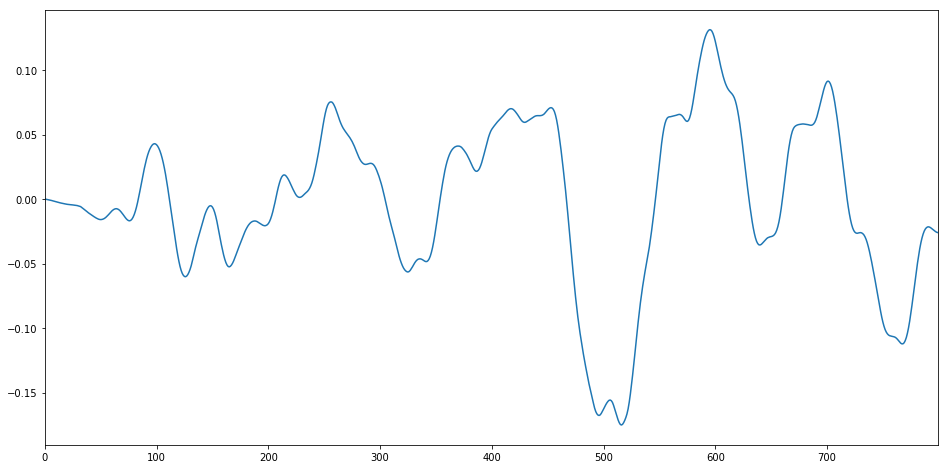

In [71]:
pd.Series(X_tr_n[:800]).plot.line(figsize=(16, 8))

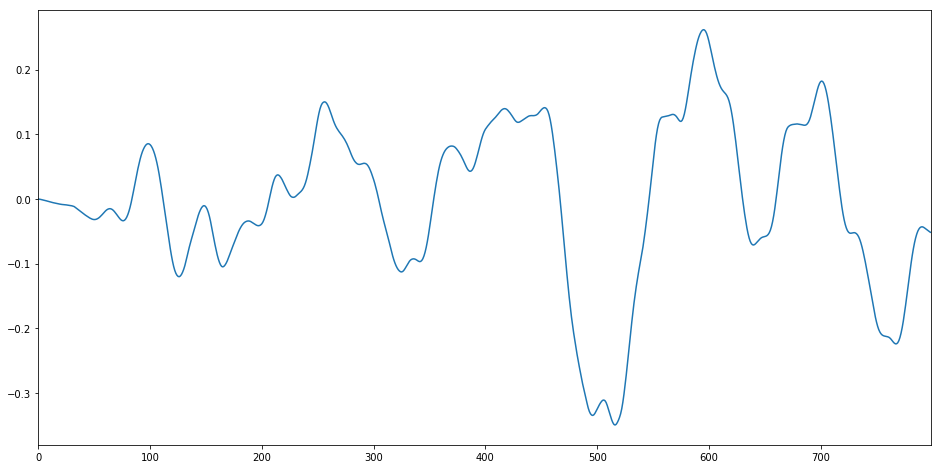

In [72]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

In [73]:

X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038, 0.23468734, 1.2222178e-05)

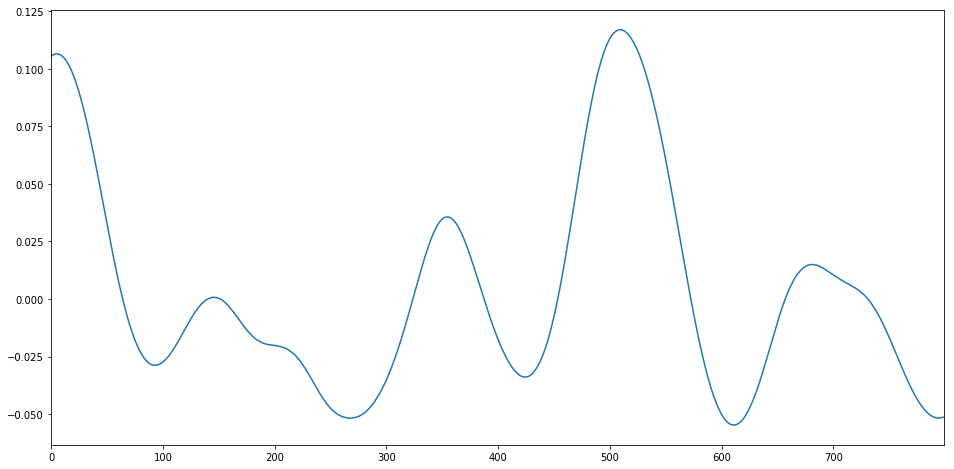

In [74]:
pd.Series(X_te_n[:800]).plot.line(figsize=(16, 8))

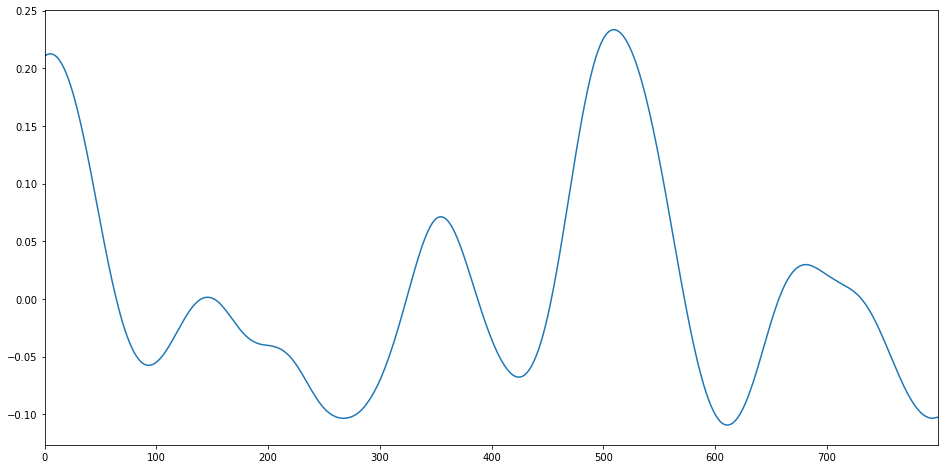

In [75]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [76]:
# appending stats of the whole sample, fading from silence

In [77]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [78]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [79]:
def make_windows(X, y, n_window_points):
    X_index = X.index
    index = 0
    
    res_X = []
    res_y = []

    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X.iloc[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y.iloc[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [80]:
%%time
(X_tr_f, y_tr_f) = make_windows(pd.Series(X_tr_n), pd.Series(y_tr_n), N_WINDOW_POINTS)
print((len(X_tr_f), X_tr_f[0], y_tr_f[0]))

(1042035, array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
       -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
       -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
       -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
       -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
       -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
       -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
       -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
       -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
       -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
       -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
       -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
       -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
       -1.55949

In [81]:
X_tr_f[1], y_tr_f[1]

(array([-0.00015259, -0.0003357 , -0.00054933, -0.00073244, -0.00091556,
        -0.00112918, -0.00140385, -0.00161748, -0.00186163, -0.00210578,
        -0.00238044, -0.00259407, -0.0028077 , -0.00302133, -0.00323496,
        -0.00338755, -0.00354015, -0.00375378, -0.00393689, -0.00408948,
        -0.00421155, -0.00430311, -0.00439467, -0.0044557 , -0.00457778,
        -0.00469985, -0.00479141, -0.004944  , -0.00506607, -0.00531022,
        -0.00552385, -0.00585955, -0.00650044, -0.00714133, -0.00787378,
        -0.00854518, -0.00927763, -0.00994903, -0.01068148, -0.01129185,
        -0.0118717 , -0.01248207, -0.01306192, -0.01367229, -0.01422163,
        -0.01474044, -0.01519822, -0.01559496, -0.01583911, -0.01593066,
        -0.01583911, -0.01559496, -0.01519822, -0.01461837, -0.01388592,
        -0.0130314 , -0.01211585, -0.01113926, -0.01019318, -0.00924711,
        -0.00851466, -0.00793481, -0.00759911, -0.00747703], dtype=float32),
 -0.014923551)

In [82]:
%%time
(X_te_f, y_te_f) = make_windows(pd.Series(X_te_n), pd.Series(y_te_n), N_WINDOW_POINTS)
print((len(X_te_f), X_te_f[0], y_te_f[0]))

(260482, array([0.105533  , 0.10586871, 0.1061739 , 0.10635701, 0.1065096 ,
       0.10654011, 0.10647908, 0.10635701, 0.1061739 , 0.10592975,
       0.105533  , 0.10507523, 0.10455641, 0.10391553, 0.1032136 ,
       0.10242012, 0.10153508, 0.10058901, 0.09955138, 0.09839167,
       0.09720145, 0.09588916, 0.09454634, 0.09305093, 0.09155553,
       0.08990753, 0.08822901, 0.08648945, 0.08465835, 0.0827662 ,
       0.08084353, 0.07882931, 0.07672353, 0.07458724, 0.07238991,
       0.07016205, 0.06787317, 0.06552324, 0.0631428 , 0.06073184,
       0.05829035, 0.05578784, 0.05328532, 0.0507828 , 0.04821924,
       0.04565569, 0.04306162, 0.04049806, 0.03790399, 0.03530991,
       0.03277688, 0.03021332, 0.02764977, 0.02517777, 0.02264473,
       0.02023377, 0.01782281, 0.01544237, 0.01312296, 0.01083407,
       0.00860622, 0.00640889, 0.00424207, 0.00219733], dtype=float32), 0.0043336283)
CPU times: user 40.4 s, sys: 1.37 s, total: 41.8 s
Wall time: 44.3 s


In [83]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_tr_f))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_te_f))
# np.random.shuffle(test_shuffle_index)

# X_tr_f = np.array(X_tr_f)[train_shuffle_index]
# y_tr_f = np.array(y_tr_f)[train_shuffle_index]

# X_te_f = np.array(X_te_f)[test_shuffle_index]
# y_te_f = np.array(y_te_f)[test_shuffle_index]

# X_tr_f[0], y_tr_f[0], len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f)

In [84]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [85]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(1042035, 1042035, 260482, 260482)

In [86]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

In [ ]:
from matplotlib import pyplot as plt

# amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

f = plt.figure(figsize=(19, 15))
plt.matshow(amp_df.corr())
plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

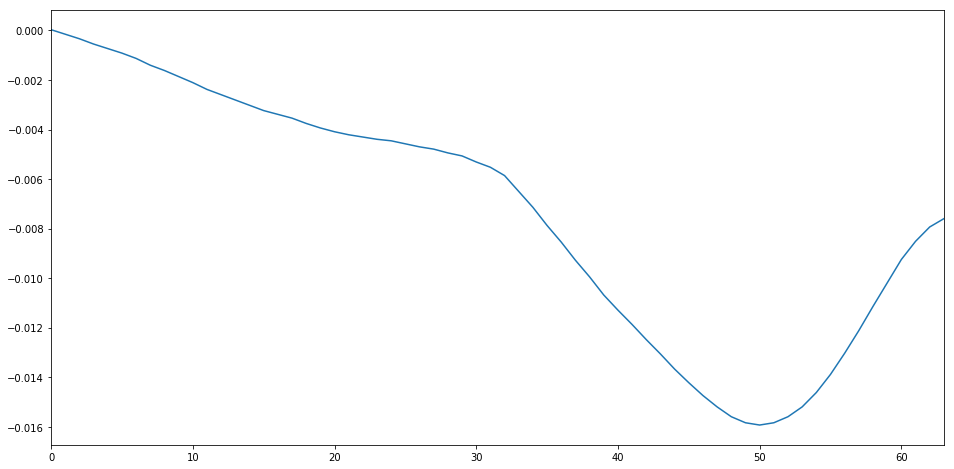

In [88]:
pd.Series(X_tr_f[0]).plot.line(figsize=(16, 8))

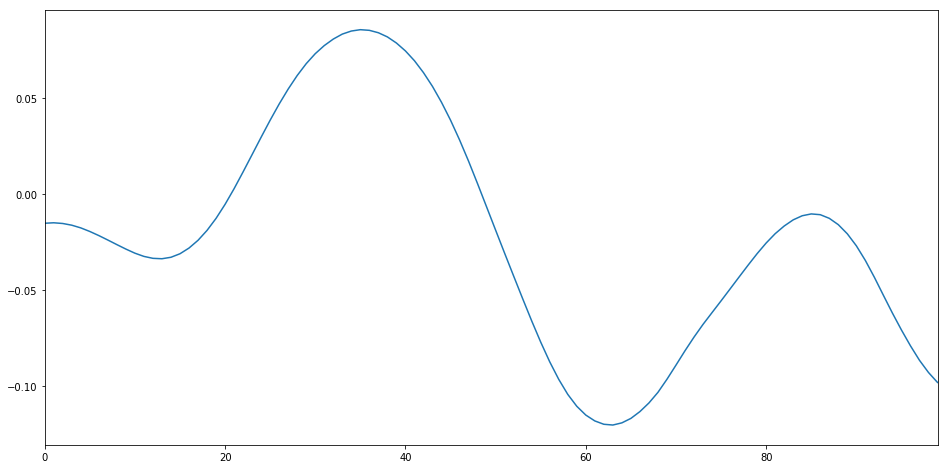

In [89]:
pd.Series(y_tr_f[:100]).plot.line(figsize=(16, 8))

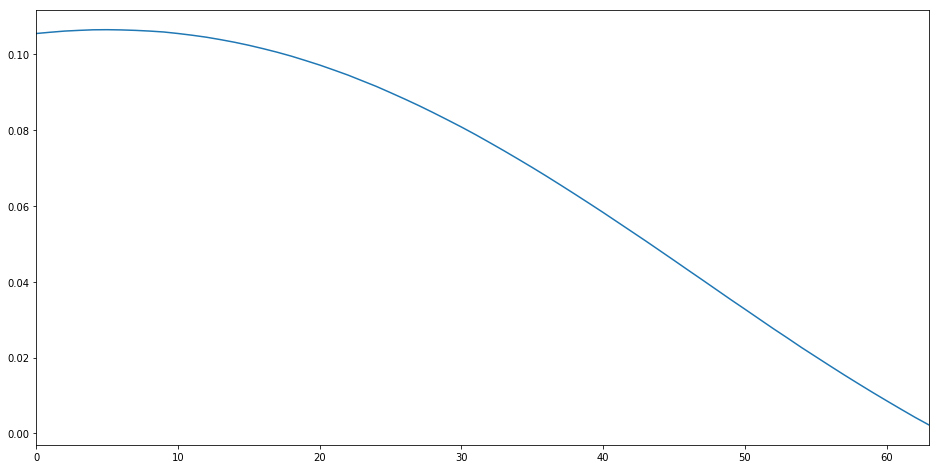

In [90]:
pd.Series(X_te_f[0]).plot.line(figsize=(16, 8))

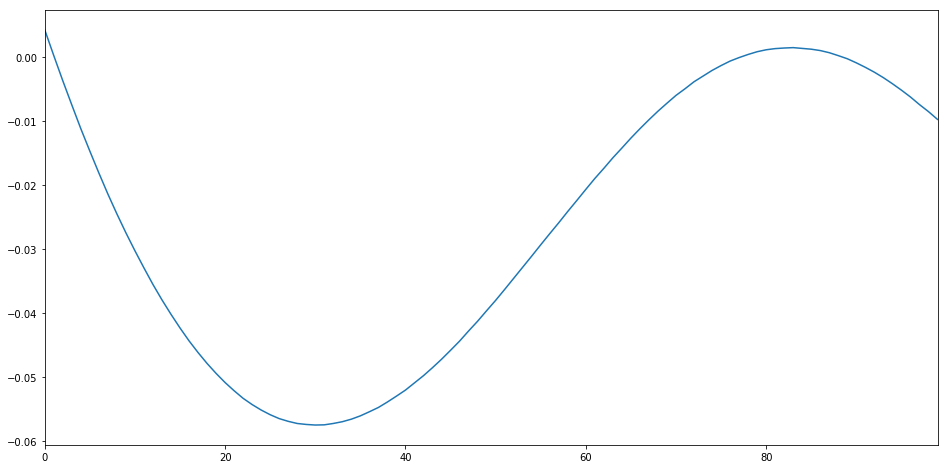

In [91]:
pd.Series(y_te_f[:100]).plot.line(figsize=(16, 8))

In [92]:
n_features = 1

In [93]:
(X_tr_f[0], y_tr_f[0])

(array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
        -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
        -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
        -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
        -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
        -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
        -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
        -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
        -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
        -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
        -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
        -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
        -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
        -1.5

In [94]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], n_features)
X_tr_s[0]

array([[ 3.05185094e-05],
       [-1.52592547e-04],
       [-3.35703604e-04],
       [-5.49333170e-04],
       [-7.32444227e-04],
       [-9.15555283e-04],
       [-1.12918485e-03],
       [-1.40385143e-03],
       [-1.61748100e-03],
       [-1.86162908e-03],
       [-2.10577715e-03],
       [-2.38044374e-03],
       [-2.59407330e-03],
       [-2.80770287e-03],
       [-3.02133244e-03],
       [-3.23496200e-03],
       [-3.38755455e-03],
       [-3.54014710e-03],
       [-3.75377666e-03],
       [-3.93688772e-03],
       [-4.08948027e-03],
       [-4.21155430e-03],
       [-4.30310983e-03],
       [-4.39466536e-03],
       [-4.45570238e-03],
       [-4.57777642e-03],
       [-4.69985045e-03],
       [-4.79140598e-03],
       [-4.94399853e-03],
       [-5.06607257e-03],
       [-5.31022064e-03],
       [-5.52385021e-03],
       [-5.85955381e-03],
       [-6.50044251e-03],
       [-7.14133121e-03],
       [-7.87377544e-03],
       [-8.54518265e-03],
       [-9.27762687e-03],
       [-9.9

In [95]:
y_tr_s = y_tr_f

In [96]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], n_features)
X_te_s[0]

array([[0.105533  ],
       [0.10586871],
       [0.1061739 ],
       [0.10635701],
       [0.1065096 ],
       [0.10654011],
       [0.10647908],
       [0.10635701],
       [0.1061739 ],
       [0.10592975],
       [0.105533  ],
       [0.10507523],
       [0.10455641],
       [0.10391553],
       [0.1032136 ],
       [0.10242012],
       [0.10153508],
       [0.10058901],
       [0.09955138],
       [0.09839167],
       [0.09720145],
       [0.09588916],
       [0.09454634],
       [0.09305093],
       [0.09155553],
       [0.08990753],
       [0.08822901],
       [0.08648945],
       [0.08465835],
       [0.0827662 ],
       [0.08084353],
       [0.07882931],
       [0.07672353],
       [0.07458724],
       [0.07238991],
       [0.07016205],
       [0.06787317],
       [0.06552324],
       [0.0631428 ],
       [0.06073184],
       [0.05829035],
       [0.05578784],
       [0.05328532],
       [0.0507828 ],
       [0.04821924],
       [0.04565569],
       [0.04306162],
       [0.040

In [97]:
y_te_s = y_te_f

In [98]:
# def add_stats(row):
#     stats = [
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
#     ]

#     return np.array([(list(x) + list(stats)) for x in row])

In [99]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [100]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

## Finished data processing!

## Moving on to training NN

In [101]:
import numpy as np

In [102]:
# num_steps=100, 24 hidden states

In [103]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import L1L2

tf.set_random_seed(1234)

In [104]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((1042035, 64, 1), (1042035,), (260482, 64, 1), (260482,))

In [105]:
y_tr_s

array([-0.0151677 , -0.01492355, -0.01528977, ...,  0.20474868,
        0.20621356,  0.2075869 ], dtype=float32)

In [106]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [110]:
N_UNITS = 10
n_features = 1
BATCH_SIZE = 100

best_params = {
  'lr': 0.01,
  'n_units': 10,
  'batch_size': 1,
  'optimizer': keras.optimizers.adam,
}


model = Sequential()

# model.add(LSTM(
#      10,
#      activation='relu',
#      stateful=True,
#      reset_after=True,
#      input_shape=(n_steps, n_features),
#      batch_input_shape=(1, n_steps, 1)
# ))

def loss(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
    
model.add(GRU(
          N_UNITS,
          input_shape=(N_WINDOW_POINTS, n_features),
          # bias_regularizer=L1L2(l1=0.1, l2=0.1),
          stateful=True,
          # reset_after=True,
          # recurrent_activation='sigmoid',
          batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
          # return_sequences=True,
))

# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.01, l2=0.01),
#           stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
#           batch_input_shape=(BATCH_SIZE, N_WINDOW_POINTS, n_features),
#           # return_sequences=True
# ))

# model.add(GRU(
#           N_UNITS,
#           input_shape=(N_WINDOW_POINTS, n_features),
#           # bias_regularizer=L1L2(l1=0.01, l2=0.01),
#           # stateful=True,
#           # reset_after=True,
#           # recurrent_activation='sigmoid',
# ))
          # return_sequences=True))

# model.add(GaussianNoise(0.01))

model.add(Dense(1))

optimizer = keras.optimizers.adam(lr=best_params['lr'])
# optimizer = keras.optimizers.SGD(lr=0.1, decay=0.2)

model.compile(optimizer=optimizer, loss='mae')

In [111]:
%%time

# TRAIN

N_SAMPLES = 8800
# N_SAMPLES = 8800
# N_SAMPLES = 100

es_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=0,
    mode='auto',
)

history = model.fit(
    X_tr_s[:N_SAMPLES],
    y_tr_s[:N_SAMPLES],
    batch_size=BATCH_SIZE,
    epochs=400,
    verbose=1,
    validation_data=(X_te_s[:4000], y_te_s[:4000]),
    callbacks=[es_cb],
)


Instructions for updating:
Use tf.cast instead.
Train on 8800 samples, validate on 4000 samples
Epoch 1/400
8800/8800 [==============================] - 4s 400us/step - loss: 0.0217 - val_loss: 0.0058
Epoch 2/400
8800/8800 [==============================] - 3s 319us/step - loss: 0.0045 - val_loss: 3.1211e-04
Epoch 3/400
8800/8800 [==============================] - 3s 311us/step - loss: 0.0033 - val_loss: 5.9999e-04
Epoch 4/400
8800/8800 [==============================] - 3s 315us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5/400
8800/8800 [==============================] - 3s 330us/step - loss: 0.0036 - val_loss: 0.0022
CPU times: user 31.7 s, sys: 12.5 s, total: 44.2 s
Wall time: 15.4 s


In [113]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[array([[-0.27705786,  0.09050278, -0.27088055, -0.29004776,  0.24862647,
         0.05894395,  0.36553565,  0.460874  , -0.3337404 ,  0.22020833,
        -0.23906736, -0.10563618,  0.4078972 ,  0.30390367,  0.05043464,
         0.05497706,  0.55124027, -0.22386393,  0.00425009,  0.24697417,
        -0.6761237 ,  0.6324113 ,  0.4192479 , -0.5187322 ,  0.05363408,
         0.30658457, -0.02644712, -0.10546784,  0.54369307,  0.47371578]],
      dtype=float32), array([[ 1.64736778e-01,  2.07346097e-01, -2.55377650e-01,
         1.43895224e-01, -1.30564526e-01,  2.12089419e-01,
        -1.68900136e-02,  2.07206473e-01,  1.90007657e-01,
         4.61248271e-02, -4.43927467e-01,  4.18630540e-02,
         3.75724845e-02, -1.72075555e-02, -1.13107994e-01,
        -2.17934340e-01, -9.02241468e-02,  2.20539030e-02,
        -7.26248100e-02,  9.88441780e-02,  1.73831537e-01,
         8.69251788e-02, -8.15715641e-02, -2.70488203e-01,
         4.93396044e-01, -3.37639630e-01, -3.68442416e-01,
      

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (100, 10)                 360       
_________________________________________________________________
dense_3 (Dense)              (100, 1)                  11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [115]:
score = model.evaluate(X_te_s[:400], y_te_s[:400], verbose=0, batch_size=BATCH_SIZE)
score

0.0024052269873209298

In [116]:
0.002701892083277926

0.002701892083277926

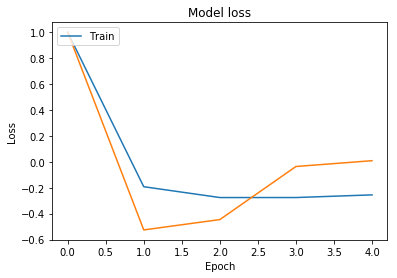

In [117]:
from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [118]:
len(X_te_f)

260482

In [119]:
import math

def predict(model, X_input):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / BATCH_SIZE) * BATCH_SIZE)], batch_size=BATCH_SIZE
        )
    ).flatten()

In [120]:
predict(model, X_te_s[:100])

array([ 0.00578012,  0.0018266 , -0.00199937, -0.00573646, -0.00933211,
       -0.01278593, -0.0160703 , -0.019254  , -0.02234541, -0.02524588,
       -0.02801549, -0.03063765, -0.03312898, -0.03550209, -0.0377187 ,
       -0.03979275, -0.04178605, -0.0435665 , -0.04524212, -0.04679251,
       -0.04817678, -0.04937155, -0.05050153, -0.051485  , -0.05235922,
       -0.05304273, -0.0536445 , -0.05404617, -0.05439463, -0.05452035,
       -0.05452881, -0.05448994, -0.05433743, -0.0540883 , -0.05373003,
       -0.05321069, -0.05258457, -0.05185954, -0.05106722, -0.05013913,
       -0.04919069, -0.04814626, -0.04700983, -0.04576113, -0.04447312,
       -0.04307104, -0.0416543 , -0.0401374 , -0.0386494 , -0.03708336,
       -0.03542101, -0.03376283, -0.03209683, -0.03038501, -0.02864604,
       -0.02690423, -0.02517018, -0.02348404, -0.02182489, -0.02016764,
       -0.01846023, -0.01676291, -0.01512914, -0.01357494, -0.01209177,
       -0.01058465, -0.00912355, -0.00778075, -0.00649852, -0.00

In [121]:
print(X_tr_s[0][-1])

[-0.00759911]


0   -0.012832
1   -0.012620
2   -0.013004
3   -0.013898
4   -0.015299
dtype: float32


Text(0,0.5,'value')

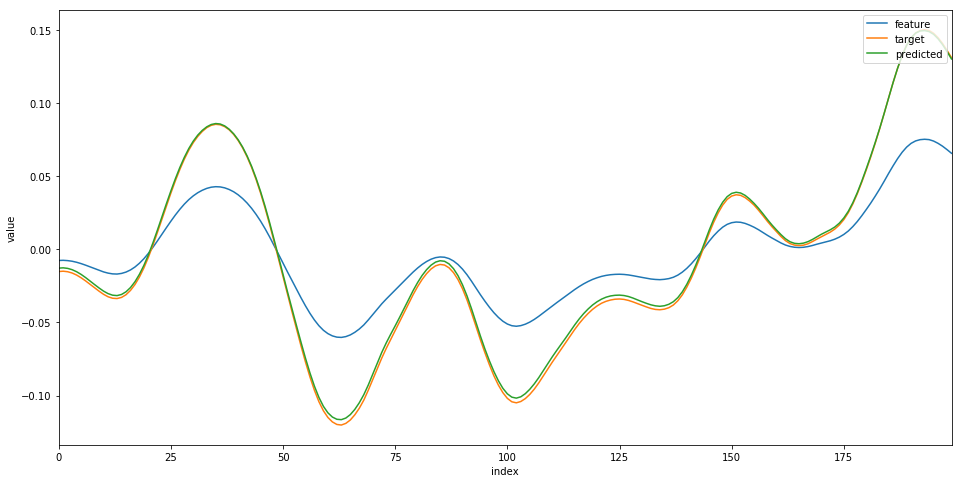

In [122]:
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 200

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

feat.plot.line(ax=ax, label='feature')

targ = (pd.Series((y_tr_s[:I])))

pred = pd.Series(predict(model, X_tr_s[:I]))
pred = (pred)

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')

## Time to evaluate performance

In [ ]:
predictions = predict(model, X_tr_f[:10000])
len(predictions), predictions[:10]

In [ ]:
wavfile.write('output/clean_train_pred_out.wav', source_clean_fs, predictions)

In [ ]:
len(predictions)